# Imports

In [176]:
import pyxdf
import pandas as pd
import numpy as np
import sounddevice as sd
from glob import glob
from tqdm import tqdm
import datetime
import time
import re
import matplotlib.pyplot as plt
from pprint import pprint


In [177]:
sub_files

['../../../Data/sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5942694/sub-P5942694_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5287460/sub-P5287460_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5813427/sub-P5813427_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5070899/sub-P5070899_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [178]:
sub_files = glob('../../../Data/*/*.xdf')

def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

In [314]:
streams_collected

['Stimuli_Markers',
 'Tobii',
 'WebcamStream',
 'EGI NetAmp 0',
 'OpenSignals',
 'Microphone']

In [310]:
sub_number = 3
xdf_path = sub_files[sub_number]
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]


In [311]:
# ET data
ET = data[streams_collected.index('Tobii')]
et_dat = ET['time_series']
column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]
et_df = pd.DataFrame(data=et_dat, columns=column_labels)
et_df['lsl_time_stamp'] = ET['time_stamps']
et_df['diff'] = et_df['lsl_time_stamp'].diff()

# stim
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
story_onsets = [20, 30, 40, 50, 60, 70]
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['diff'] = stim_df['lsl_time_stamp'].diff()

# mic
mic_data = data[streams_collected.index('Microphone')]
mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
mic_df['lsl_time_stamp'] = mic_data['time_stamps']
mic_df['diff'] = mic_df['lsl_time_stamp'].diff()

# video
cam_data = data[streams_collected.index('WebcamStream')]
cam_data['time_series'][0]
frame_nums = [int(i[0]) for i in cam_data['time_series']]
time_pre = [float(i[1]) for i in cam_data['time_series']]
time_evnt_ms = [float(i[2]) for i in cam_data['time_series']]
time_post = [float(i[3]) for i in cam_data['time_series']]
cam_df = pd.DataFrame({'frame_num': frame_nums, 
                    'time_pre': time_pre, 
                    'cap_time_ms': time_evnt_ms,
                    'time_post': time_post,
                    'lsl_time_stamp': cam_data['time_stamps']})

cam_df['frame_time_sec'] = (cam_df.cap_time_ms - cam_df.cap_time_ms[0])/1000
cam_df['lsl_time_sec'] = cam_df.lsl_time_stamp #- cam_df.lsl_time_stamp[0]
cam_df['diff'] = cam_df['lsl_time_sec'].diff()


# eeg
eeg_dat = data[streams_collected.index('EGI NetAmp 0')]
eeg_df = pd.DataFrame(eeg_dat['time_series'])
eeg_df['lsl_time_stamp'] = eeg_dat['time_stamps']
eeg_df['diff'] = eeg_df['lsl_time_stamp'].diff()

# physio
PS = data[streams_collected.index('OpenSignals')]
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['diff'] = ps_df['lsl_time_stamp'].diff()
    
    

In [209]:
import math
# is the number of diffs within 1e-2 of 1/120 the same as len-1
sum([math.isclose(x, 1/120, abs_tol=1e-2) for x in et_df.lsl_time_stamp.diff()]) == len(et_df) - 1

False

In [73]:
srate = ET['info']['effective_srate']
srate

119.99595937396289

In [220]:
tf = [math.isclose(x, 1/srate, abs_tol=1e-2) for x in et_df.lsl_time_stamp.diff()]

In [224]:
# get indices where tf == False
tf_array = np.array(tf)
np.where(tf_array == False)[0]

# [i for i, val in enumerate(tf) if not val]

array([     0, 182952])

In [229]:
# this is how you should find indexes of where diff is not as expected
loss_index = np.where(et_df['diff'] > 1/srate+.01)[0]
loss_index
# or np.where(et_df['diff'] > et_df['diff'].median()+.01)[0]


array([182952])

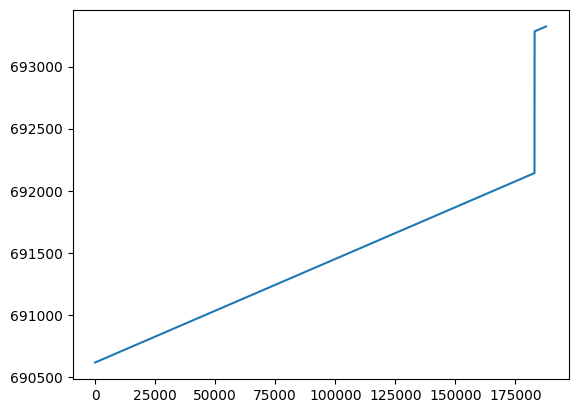

In [77]:
ax = plt.plot(et_df['lsl_time_stamp'])
ax

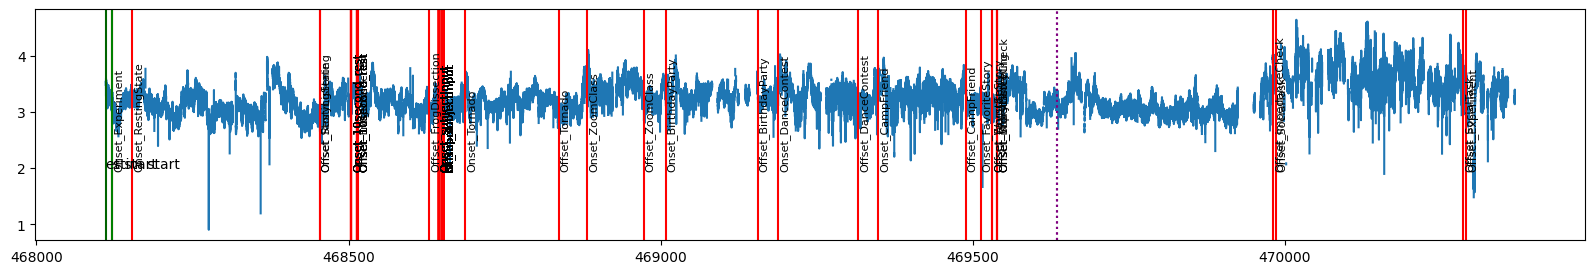

In [315]:
plt.figure(figsize = (20, 3))
plt.plot(et_df['lsl_time_stamp'], et_df['right_pupil_diameter'])
evs = stim_df.loc[stim_df.event != 'psychopy_time_stamp']
for event1 in evs['event']:
    plt.axvline(stim_df.loc[stim_df.event == event1, 'lsl_time_stamp'].values[0], color='r')
    plt.text(stim_df.loc[stim_df.event == event1, 'lsl_time_stamp'].values[0]+2, 2, event1, rotation=90, fontsize = 8)

plt.axvline(et_df.loc[loss_index[0], 'lsl_time_stamp'], color='purple', linestyle = ':')
plt.axvline(et_df.loc[loss_index[0]-1, 'lsl_time_stamp'], color='purple', linestyle = ':')


plt.axvline(stim_start, color = 'green')
plt.text(stim_start+1, 2, 'stim start')
plt.axvline(et_start, color = 'darkgreen')
plt.text(et_start+1, 2, 'et start')

plt.show()


# Percentage of missing data 

In [80]:
# df with percent loss (diff greater than median)
modalities = ['et', 'ps', 'mic', 'cam', 'eeg']
percent_list = []

timestamp = int(stim_df.loc[stim_df['event'] == 'psychopy_time_stamp', 'trigger'].iloc[0])
date_object = datetime.datetime.fromtimestamp(timestamp)
date_string = date_object.strftime("%Y-%m-%d")

for modality in modalities:
    df = globals()[modality+'_df']
    subject = sub_files[sub_number].split('/')[4].split('-')[1]

    
    # median diff between lsl_time_stamp (with 1.05 margin) 
    median1 = df['diff'].median() * 1.05
    # number of loss instances  
    loss_instances = (df['diff'] > median1).sum()
    if loss_instances != 0:
        # amount of data skipped: values for which diff>median 
        amt_data_lost = df.loc[df['diff'] > median1, 'diff'].values[0].sum()
        # total amount of data: last - first lsl_time_stamp
        amt_data_total = df['lsl_time_stamp'].values[-1] - df['lsl_time_stamp'].values[0]

        percent_lost = round(amt_data_lost/amt_data_total * 100, 3)
    else:
        percent_lost = 0
    percent_list.append({'sub_num':sub_number, 'date': date_string, 'subject': subject, 'modality': modality, 'num_losses': loss_instances, 'percent_lost': percent_lost})
        
percent_data_loss = pd.DataFrame(percent_list)
percent_data_loss.sort_values(by='date', inplace=True, ascending=True)
percent_data_loss


,sub_num,date,subject,modality,num_losses,percent_lost
0,9,2024-10-08,P5548165,et,1,42.149
1,9,2024-10-08,P5548165,ps,3,1.379
2,9,2024-10-08,P5548165,mic,0,0.000
3,9,2024-10-08,P5548165,cam,1,1.739
4,9,2024-10-08,P5548165,eeg,0,0.000


In [81]:
nonzero_loss = percent_data_loss[percent_data_loss['percent_lost'] != 0]
nonzero_loss

,sub_num,date,subject,modality,num_losses,percent_lost
0,9,2024-10-08,P5548165,et,1,42.149
1,9,2024-10-08,P5548165,ps,3,1.379
3,9,2024-10-08,P5548165,cam,1,1.739


In [82]:
# df with number of diff significantly BELOW median
short_diff_list = []

for modality in modalities:
    df = globals()[modality+'_df']
    subject = sub_files[sub_number].split('/')[4].split('-')[1]
    
    # median diff between lsl_time_stamp (lower bound) (.99 for rounding)
    median2 = df['diff'].median() * .99
    # number of loss instances  
    short_instances = (df['diff'] < median2).sum()

    short_diff_list.append({'sub_num':sub_number, 'date': date_string, 'subject': subject, 'modality': modality, 'num_short': short_instances})
        
short_diff_df = pd.DataFrame(short_diff_list)
short_diff_df

,sub_num,date,subject,modality,num_short
0,9,2024-10-08,P5548165,et,0
1,9,2024-10-08,P5548165,ps,0
2,9,2024-10-08,P5548165,mic,0
3,9,2024-10-08,P5548165,cam,0
4,9,2024-10-08,P5548165,eeg,0


# Amount of loss before offset_socialtask

In [181]:
# df with percent loss (diff greater than median), before social task offset
offset_social_timestamp = stim_df.loc[stim_df['event'] == 'Offset_SocialTask', 'lsl_time_stamp'].values[0]
social_percent_list = []
subject = sub_files[sub_number].split('/')[4].split('-')[1]


for modality in modalities:
    df = globals()[modality+'_df']
    social_df = df.loc[df.lsl_time_stamp <= offset_social_timestamp]

    # median diff between lsl_time_stamp (with 1.05 margin) 
    median1 = df['diff'].median() * 1.05

    # number of loss instances  
    loss_instances = (social_df['diff'] > median1).sum()
    percent_lost = 0
    amt_data_lost = 0

    # LSL loss starts and ends before offset_social
    if loss_instances != 0:
        # amount of data skipped: values for which diff>median 
        amt_data_lost = social_df.loc[social_df['diff'] > median1, 'diff'].values[0].sum()

    # offset social is between LSL loss onset + offset
    remaining_lost = offset_social_timestamp - social_df['lsl_time_stamp'].values[-1]
    if (remaining_lost) > 1:
        loss_instances +=1
        amt_data_lost = amt_data_lost + remaining_lost

    amt_data_total = offset_social_timestamp - social_df['lsl_time_stamp'].values[0]
    percent_lost = round(amt_data_lost/amt_data_total * 100, 3)

    social_percent_list.append({'sub_num':sub_number, 'date': date_string, 'subject': subject, 'modality': modality, 'num_losses': loss_instances, 'percent_lost': percent_lost})
        
percent_data_loss_social = pd.DataFrame(social_percent_list)
percent_data_loss_social.sort_values(by='date', inplace=True, ascending=True)
percent_data_loss_social



0.002724714344367385
0.0011933763162232935
1.492892624810338e-05
0.022955443942919374
0.0008368722046725452


,sub_num,date,subject,modality,num_losses,percent_lost
0,1,2024-10-08,P5942694,et,0,0.0
1,1,2024-10-08,P5942694,ps,0,0.0
2,1,2024-10-08,P5942694,mic,0,0.0
3,1,2024-10-08,P5942694,cam,0,0.0
4,1,2024-10-08,P5942694,eeg,0,0.0


In [182]:
nonzero_loss_social = percent_data_loss_social[percent_data_loss_social['percent_lost'] != 0]
nonzero_loss_social

,sub_num,date,subject,modality,num_losses,percent_lost


## LSL start times

In [313]:
stim_start = stim_df['lsl_time_stamp'][0]
mic_start = mic_df['lsl_time_stamp'][0]
cam_start = cam_df['lsl_time_stamp'][0]
ps_start = ps_df['lsl_time_stamp'][0]
eeg_start = eeg_df['lsl_time_stamp'][0]
et_start = et_df['lsl_time_stamp'][0]

lsl_start_df = pd.DataFrame(columns = ['modality', 'lsl_start'])
lsl_start_df['modality'] = modalities
lsl_start_df['lsl_start'] = [et_start, ps_start, mic_start, cam_start, eeg_start, stim_start]
lsl_start_df.sort_values(by = 'lsl_start')

,modality,lsl_start
0,et,468110.885841
4,eeg,468110.898469
3,cam,468110.932633
1,ps,468111.050621
5,stim,468121.675961
2,mic,468482.351987


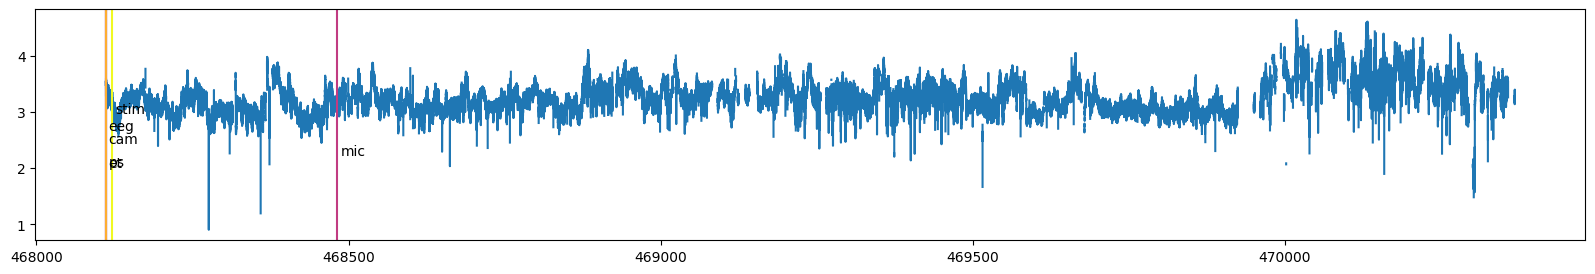

In [322]:
stim_start = stim_df['lsl_time_stamp'][0]
mic_start = mic_df['lsl_time_stamp'][0]
cam_start = cam_df['lsl_time_stamp'][0]
ps_start = ps_df['lsl_time_stamp'][0]
eeg_start = eeg_df['lsl_time_stamp'][0]
et_start = et_df['lsl_time_stamp'][0]

plt.figure(figsize=(20, 3))
plt.plot(et_df['lsl_time_stamp'], et_df['right_pupil_diameter'])

colors = plt.cm.plasma(np.linspace(.1, 1, len(modalities)))

for color, modality in zip(colors, modalities):
    start = globals()[modality+'_start']
    plt.axvline(start, color = color)
    plt.text(start + 5, color[1]+2, f'{modality}')